<a href="https://colab.research.google.com/github/DayoungKwon/mrc/blob/main/mrc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 설치 
- khaiii (오래걸림)
- 그외 (huggingface, konlpy)

In [1]:
# !git clone https://github.com/kakao/khaiii.git
# !pip install cmake
# !mkdir build
# !cd build && cmake /content/khaiii
# !cd /content/build/ && make all
# !cd /content/build/ && make resource
# !cd /content/build && make install
# !cd /content/build && make package_python
# !pip install /content/build/package_python

In [2]:
! pip install datasets
! pip install transformers
! apt-get install -y openjdk-8-jdk python3-dev
! pip install konlpy "tweepy<4.0.0"
! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-dev is already the newest version (3.6.7-1~18.04).
openjdk-8-jdk is already the newest version (8u342-b07-0ubuntu1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mecab-ko is already installed
mecab-ko-dic is already installed
mecab-python is already installed
Done.


### Data Preparing

1. data load 
2. data preprocessing 
- 형태소 분석 
- tokenizing 


## Data Load

데이터를 로드하고, parsing 해서 필요한 데이터만 뽑아주는 모듈 
KoMRC

In [3]:
from typing import List, Tuple, Dict, Any
import json
import numpy as np
import random

class KoMRC:
    def __init__(self, data, indices: List[Tuple[int, int, int]], mode=None): #, tokenizer=None):
        self._data = data
        self._indices = indices 
        self._preprocessed_data = None

    # Json을 불러오는 메소드
    @classmethod
    def load(cls, file_path):
        with open(file_path, 'r', encoding='utf-8') as fd:
            data = json.load(fd)

        indices = []
        for d_id, document in enumerate(data['data']):
            for p_id, paragraph in enumerate(document['paragraphs']):
                for q_id, _ in enumerate(paragraph['qas']):
                    indices.append((d_id, p_id, q_id))
        
        return cls(data, indices)

    # 데이터 셋을 잘라내는 메소드
    @classmethod
    def split(cls, dataset, eval_ratio: float=.1, seed=42, mode='mecab'): #, tokenizer=None):
        indices = list(dataset._indices)
        random.seed(seed)
        random.shuffle(indices)
        train_indices = indices[int(len(indices) * eval_ratio):]
        eval_indices = indices[:int(len(indices) * eval_ratio)]

        return cls(dataset._data, train_indices, mode=mode), cls(dataset._data, eval_indices, mode=mode)#, tokenizer=tokenizer)

    def __getitem__(self, slices):
        if not self._preprocessed_data :
          self._preprocessed_data = self.__parse_rawdata(self._indices)


        if isinstance(slices, (int, np.int64)):
          # row 
          return {
              'guid': self._preprocessed_data['guid'][slices],
              'context': self._preprocessed_data['context'][slices],
              'answers': self._preprocessed_data['answers'][slices],
              'question': self._preprocessed_data['question'][slices]
          }
        elif isinstance(slices, str):
          return self._preprocessed_data[slices]
        elif isinstance(slices, slice):
          return {
              'guid': [self._preprocessed_data['guid'][i] for i in range(slices.start, slices.stop)],
              'context': [self._preprocessed_data['context'][i] for i in range(slices.start, slices.stop)],
              'answers': [self._preprocessed_data['answers'][i] for i in range(slices.start, slices.stop)],
              'question': [self._preprocessed_data['question'][i] for i in range(slices.start, slices.stop)]
          }
        raise ValueError(f'unhanled slices : {slices}, type={type(slices)}')


    def __parse_rawdata(self, indices) -> dict:

        _indices = {'question':[], 'answers':[], 
                    'context':[], 'guid':[]}

        for index, indice in enumerate(indices):
          d_id, p_id, q_id = indice
          paragraph = self._data['data'][d_id]['paragraphs'][p_id]

          qa = paragraph['qas'][q_id]
          _indices['guid'].append(qa['guid'])

          _indices['question'].append(qa['question'])
          _indices['answers'].append(qa['answers']) 
          _indices['context'].append(paragraph['context'])

        print(len(_indices['question']))
        return _indices


    def __len__(self) -> int:
        return len(self._indices)

In [4]:
# 데이터 위치 (저장하신 위치에 따라 바꿔주세요)
train_file = '/content/train.json'
test_file = '/content/test.json'
dataset = KoMRC.load(train_file)
train_dataset, dev_dataset = KoMRC.split(dataset)
print("Number of Train Samples:", len(train_dataset))
print("Number of Dev Samples:", len(dev_dataset))

print(dev_dataset[0])
print(dev_dataset[0]['answers'])
print(dev_dataset[0]['context'].split('.')[0])
print(dev_dataset['answers'])
print(len(dev_dataset['answers']))
print(dev_dataset['question'])
print(len(dev_dataset['question']))
print(dev_dataset[0:10])

Number of Train Samples: 10834
Number of Dev Samples: 1203
1203
{'guid': '844e22ab28924c1697d5ac28801b34c1', 'context': '지난해 주요 연극상을 나눠 가졌던 세 편의 작품이 올봄에 나란히 앙코르 무대를 갖는다. 대한민국연극대상 연기·무대예술상, 동아연극상 작품·희곡·연기상 등을 수상한 ‘알리바이 연대기’(17~20일 대학로 아르코예술극장 대극장, 25일~5월11일 서계동 국립극단 백성희장민호극장), 연극대상에서 대상과 희곡상을 받은 ‘여기가 집이다’(18일~5월22일 대학로 연우소극장), 연극대상 작품·연출상과 김상열연극상 수상작인 ‘황금용’(5월9~18일 서강대 메리홀 대극장)이다. 초연 당시 짧은 상연 기간과 낮은 인지도 등으로 공연을 놓친 연극팬에겐 평단으로부터 작품성을 인정받은 수작을 관람할 수 있는 기회다. ‘알리바이 연대기’는 희곡을 쓰고 연출한 김재엽의 가족사에 근거한 다큐멘터리 드라마다. 1930년에 태어난 한 개인의 사적인 연대기를 바탕으로 그 사이를 파고드는 역사적 순간들을 정밀하게 조명한다. 연출가는 “공적인 권력이 사적인 권리를 지켜주기보다 억압하기 일쑤였던 한국 현대사 속에서 개인은 언제나 무죄를 입증하며 하루하루 자신을 지켜내야 하는 ‘알리바이의 연대기’ 속에서 살아왔다”고 말한다.한국연극평론가협회는 이 작품을 ‘2013년 올해의 연극 베스트3’로 선정하며 “촘촘하고 세세하게 삶에 천착해 개인과 역사에 대한 이분법적 관점을 극복한다. 정치극에 대한 새로운 가능성을 보여줬다”고 평했다. 이 작품으로 연기상을 휩쓴 남명렬을 비롯해 지춘성 정원조 등 초연 배우들이 그대로 출연한다.‘여기가 집이다’는 허름하고 볼품 없는 ‘20년 전통’의 고시원에 모여 사는 사람들의 절망과 희망을 그린 작품. ‘차력사와 아코디언’ ‘택배 왔어요’를 만든 극단 이와삼의 장우재 대표가 직접 대본을 쓰고 연출했다. 나름의 규칙을 가지고 평화로웠던 고시원에 새로운 주인으로 등

In [5]:
# Tokenizer load 
from transformers import AutoTokenizer, AutoModel, AutoConfig

def load_tokenizer(model_id, test_sentence):
  tokenizer = AutoTokenizer.from_pretrained(hf_model_id)
  return tokenizer


In [6]:
sentence = '위메프의 배달∙픽업 서비스 위메프오가 23~25일 3일간 ‘BBQ 50% 페이백’ 이벤트를 진행한다고 23일 밝혔다'

# hf_model_id = 'kykim/electra-kor-base'
# tokenizer = load_tokenizer(hf_model_id, sentence)

# hf_model_id = 'monologg/kobert'
# tokenizer = load_tokenizer(hf_model_id, sentence)


# hf_model_id = 'kykim/bert-kor-base'
# tokenizer = load_tokenizer(hf_model_id, sentence)


hf_model_id = 'Jinhwan/krelectra-base-mecab'
tokenizer = load_tokenizer(hf_model_id, sentence)

# hf_model_id = 'monologg/kobigbird-bert-base'
# #https://github.com/monologg/KoBigBird
config = AutoConfig.from_pretrained(hf_model_id, max_position_embeddings=1024)
model = AutoModel.from_pretrained(hf_model_id)

Some weights of the model checkpoint at Jinhwan/krelectra-base-mecab were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
print(hf_model_id)
print(tokenizer) 
question = '무슨 이벤트를 하나?'
aa =tokenizer(question, sentence, return_offsets_mapping=True)
print(aa)
print(tokenizer.cls_token_id)
print(tokenizer.sep_token_id)

# answer (16,) => 7,8
# context position (
print(aa.offset_mapping)

Jinhwan/krelectra-base-mecab
PreTrainedTokenizerFast(name_or_path='Jinhwan/krelectra-base-mecab', vocab_size=32000, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})
{'input_ids': [2, 13851, 9401, 3195, 4998, 32, 3, 1944, 3240, 3072, 3322, 1, 5520, 1944, 3240, 3072, 3026, 3204, 5196, 93, 5120, 3229, 22, 3229, 3443, 1, 19311, 3665, 5414, 8, 7441, 3490, 1, 9401, 3195, 5177, 5300, 2999, 5196, 3229, 5848, 3024, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 2), (3, 6), (6, 7), (8, 10), (10, 11), (0, 0), (0, 1), (1, 2), (2, 3), (3, 4), (5, 10), (11, 14),

In [8]:
from tqdm import tqdm 
class TKIndexerWrappedDataset:
    def __init__(self, dataset: KoMRC, tokenizer) -> None:
        self._indexer = tokenizer
        self._dataset = self._sample2ids_with_tk(dataset)

    def __len__(self) -> int:
        return len(self._dataset['input_ids'])


    def _sample2ids_with_tk(self, sample):
      tokenizer = self._indexer

      # return_offsets_mapping
      tokenized = tokenizer(sample['question'], 
                            sample['context'],
                            return_overflowing_tokens=True, 
                            return_offsets_mapping=True, 
                            # stride = 128,
                            return_tensors = 'pt',
                            max_length=512, 
                            truncation='only_second', 
                            padding='max_length')
      offset_map = tokenized.pop('offset_mapping')
      overflow_map = tokenized.pop('overflow_to_sample_mapping')
      tokenized['start'] = []
      tokenized['end'] = []
      tokenized['guid'] = []
      cls_id = tokenizer.cls_token_id

      for i, offsets in enumerate(tqdm(offset_map)):
        input_ids = tokenized['input_ids'][i]
        cls_index = input_ids.tolist().index(cls_id)
        seq_ids = tokenized.sequence_ids(i)

        # check
        example_idx = overflow_map[i]
        answers = sample['answers'][example_idx]
        guid = sample['guid'][example_idx]

        # 
        ans_start = answers[0]['answer_start']
        ans_end = answers[0]['answer_start'] + len(answers[0]['text'])

        # question, context 분리 
        ans_token_start = 0 
        while seq_ids[ans_token_start] != 1 :
          ans_token_start += 1 

        ans_token_end = len(input_ids) - 1
        while seq_ids[ans_token_end] != 1 :
          ans_token_end -= 1 

        if not (offsets[ans_token_start][0] <= ans_start and offsets[ans_token_end][1] >= ans_end):
          tokenized['start'].append(cls_index)
          tokenized['end'].append(cls_index)      
          tokenized['guid'].append(guid)
        else : 
          while (ans_token_start < len(offsets) 
          and offsets[ans_token_start][0] <= ans_start): 
            ans_token_start += 1 
          
          while offsets[ans_token_end][1] >= ans_end:
            ans_token_end -= 1 

          tokenized['start'].append(ans_token_start)
          tokenized['end'].append(ans_token_end)      
          tokenized['guid'].append(guid)      
      return tokenized
      
    
    def __getitem__(self, slices) -> Any:

        if isinstance(slices, (int, np.int64)):
          # row 
          return {
              'input_ids': self._dataset['input_ids'][slices],
              'token_type_ids': self._dataset['token_type_ids'][slices],
              'attention_mask': self._dataset['attention_mask'][slices],
              'start': self._dataset['start'][slices],
              'end': self._dataset['end'][slices],
              'guid': self._dataset['guid'][slices]
          }
        elif isinstance(slices, str):
          return self._dataset[slices]
        elif isinstance(slices, slice):
          return {
              'input_ids': [self._dataset['input_ids'][i] for i in range(slices.start, slices.stop)],
              'token_type_ids': [self._dataset['token_type_ids'][i] for i in range(slices.start, slices.stop)],
              'attention_mask': [self._dataset['attention_mask'][i] for i in range(slices.start, slices.stop)],
              'guid': [self._dataset['guid'][i] for i in range(slices.start, slices.stop)],
              'start': [self._dataset['start'][i] for i in range(slices.start, slices.stop)],
              'end': [self._dataset['end'][i] for i in range(slices.start, slices.stop)]
          }
        raise ValueError(f'unhanled slices : {slices}, type={type(slices)}')

        return sample

In [9]:
indexed_train_dataset = TKIndexerWrappedDataset(train_dataset, tokenizer)
indexed_dev_dataset = TKIndexerWrappedDataset(dev_dataset, tokenizer)
print(f'\nlen origin train_dataset : {len(train_dataset)}')
print(f'len indexed_train_dataset : {len(indexed_train_dataset)}')
sample = indexed_dev_dataset[0]
print(sample['input_ids'].shape)

10834


100%|██████████| 1812/1812 [00:03<00:00, 463.07it/s]


len origin train_dataset : 10834
len indexed_train_dataset : 16594
torch.Size([512])


### Data 준비
Collator : 데이터를 batch에 맞게 자르고 묶어주고, 준비하는 모듈
DataLoader : 데이터를 iterative (돌아가면서 훈련할 수 있게) Load하는 모듈 


In [10]:
import torch
from torch.nn.utils.rnn import pad_sequence

class Collator:
    def __init__(self, indexer) -> None:
        self._indexer = indexer

    def __call__(self, samples: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        samples = {
            key: [sample[key] for sample in samples]
            for key in samples[0]
        }

        for key in 'start', 'end':
            if samples[key][0] is None:
                samples[key] = None
            else:
                samples[key] = torch.tensor(samples[key], dtype=torch.long)
        for key in 'input_ids', 'attention_mask', 'token_type_ids':
            samples[key] = pad_sequence(
                [torch.tensor(sample, dtype=torch.long) for sample in samples[key]],
                batch_first=True, padding_value=self._indexer.pad_token_id
            )

        return samples

In [11]:
from torch.utils.data import DataLoader

batch_size = 64
#num_workers = core num
accumulation = 4 # 메모리를 아끼기 위하여 Gradient accumulation을 해보자
collator = Collator(tokenizer)
train_loader = DataLoader(indexed_train_dataset, batch_size=batch_size//accumulation, shuffle=True, collate_fn=collator, num_workers=2)
dev_loader = DataLoader(indexed_dev_dataset, batch_size=batch_size//accumulation, shuffle=False, collate_fn=collator, num_workers=2)

In [12]:
batch = next(iter(dev_loader))
print(batch['input_ids'].shape)
print(list(batch.keys()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


torch.Size([16, 512])
['input_ids', 'token_type_ids', 'attention_mask', 'start', 'end', 'guid']


In [13]:
print(len(train_loader))
print(len(indexed_train_dataset))
print(len(indexed_train_dataset)/16)

1038
16594
1037.125


## 본격적으로 훈련하기
1. 모델 hyperparameter 정하기
2. Training


In [14]:
!pip install transformers
import torch.nn as nn

from transformers.models.bert.modeling_bert import (
    BertModel,
    BertPreTrainedModel
)
from transformers import AutoModel
## Simple Version for Bert QA: https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForQuestionAnswering.forward
class BertForQuestionAnswering(nn.Module):
    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config, hf_model_id):
        # super().__init__(config)
        # self.bert = BertModel(config, add_pooling_layer=False)
        # self.start_linear = nn.Linear(config.hidden_size, 1)
        # self.end_linear = nn.Linear(config.hidden_size, 1)
        # self.init_weights()

        super().__init__()
        self.bert = AutoModel.from_pretrained(hf_model_id)
        self.start_linear = nn.Linear(self.bert.config.hidden_size, 1)
        self.end_linear = nn.Linear(self.bert.config.hidden_size, 1)


    def forward(
        self, input_ids, attention_mask, token_type_ids
    ):
        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        start_logits = self.start_linear(outputs.last_hidden_state).squeeze(-1)
        end_logits = self.end_linear(outputs.last_hidden_state).squeeze(-1)

        return start_logits, end_logits

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import torch
from transformers import BertConfig


print(f'Encoder model to use : {hf_model_id}')
model = BertForQuestionAnswering({}, hf_model_id)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)


Encoder model to use : Jinhwan/krelectra-base-mecab


Some weights of the model checkpoint at Jinhwan/krelectra-base-mecab were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [16]:
# device set
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.cuda()


BertForQuestionAnswering(
  (bert): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

In [17]:
from torch.utils.data import RandomSampler, DataLoader, Subset
import numpy as np 

num_train_samples = 16
sample_ds = Subset(indexed_train_dataset, np.arange(num_train_samples))
sample_sampler = RandomSampler(sample_ds)
sample_dl = DataLoader(sample_ds, collate_fn=collator, sampler=sample_sampler, batch_size=4)
next(iter(sample_dl))

num_dev_samples = 2
sample_ds_dev = Subset(indexed_dev_dataset, np.arange(num_dev_samples))
sample_sampler_dev = RandomSampler(sample_ds_dev)
sample_dl_dev = DataLoader(sample_ds_dev, collate_fn=collator, sampler=sample_sampler_dev, batch_size=4)
next(iter(sample_dl_dev))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


{'input_ids': tensor([[   2, 1957, 3021,  ...,    0,    0,    0],
         [   2, 1957, 3021,  ..., 3090,    1,    3]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 1, 1, 1]]),
 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 1, 1, 1]]),
 'start': tensor([  0, 169]),
 'end': tensor([  0, 171]),
 'guid': ['844e22ab28924c1697d5ac28801b34c1',
  '844e22ab28924c1697d5ac28801b34c1']}

In [18]:
import os
from statistics import mean

import torch.nn.functional as F
from torch.nn.utils import clip_grad_norm_
print(f'device : {device}')
os.makedirs('dump', exist_ok=True)
train_losses = []
dev_losses = []

step = 0


for epoch in range(1, 31):
    print("Epoch", epoch)
    # Training
    running_loss = 0.
    losses = []
    progress_bar = tqdm(sample_dl, desc='Train')
    for batch in progress_bar:
        del batch['guid'] #, batch['context'], batch['question'], batch['position']
        # batch = {key: value.cuda() for key, value in batch.items()}
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['token_type_ids'] = batch['token_type_ids'].to(device)
        batch['attention_mask'] = batch['attention_mask'].to(device)
        batch['start'] = batch['start'].to(device)
        batch['end'] = batch['end'].to(device)

        start = batch.pop('start')
        end = batch.pop('end')
        
        model_output = model(**batch)
        
        try :
          start_logits, end_logits = model_output
        except Exception as e :
          print(model_output)
          raise e 
        
        try :
          print('loss')
          loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

          print(torch.argmax(start_logits, dim=1))
          print(start)
          print(f'ce1 : {F.cross_entropy(start_logits, start)}')
          print(f'ce2 : {F.cross_entropy(end_logits, end)}')

          loss.backward()
          running_loss += loss.item()
          print(f'running_loss : {running_loss}')
        except Exception as e :
          print(f'start_logits : {start_logits}')
          print(f'end_logits : {end_logits}')
          print(f'start : {start}')
          print(f'end : {end}')
          print(f'loss : {loss}')
          raise e 
        del batch, start, end, start_logits, end_logits, loss
        
        step += 1
        # if step % accumulation:
        #     continue

        clip_grad_norm_(model.parameters(), max_norm=1.)
        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        losses.append(running_loss)
        running_loss = 0.
        progress_bar.set_description(f"Train - Loss: {losses[-1]:.3f}")

    train_losses.append(mean(losses))
    print(f"train score: {train_losses[-1]:.3f}")

    # Evaluation
    losses = []
    for batch in tqdm(sample_dl_dev, desc="Evaluation"):
        del batch['guid'] #, batch['context'], batch['question'], batch['position']
        # batch = {key: value.cuda() for key, value in batch.items()}
        batch['input_ids'] = batch['input_ids'].to(device)
        batch['token_type_ids'] = batch['token_type_ids'].to(device)
        batch['attention_mask'] = batch['attention_mask'].to(device)
        batch['start'] = batch['start'].to(device)
        batch['end'] = batch['end'].to(device)

        start = batch.pop('start')
        end = batch.pop('end')
        
        with torch.no_grad():
            start_logits, end_logits = model(**batch)
        loss = F.cross_entropy(start_logits, start) + F.cross_entropy(end_logits, end)

        losses.append(loss.item())
        del batch, start, end, start_logits, end_logits, loss
    dev_losses.append(mean(losses))
    print(f"Evaluation score: {dev_losses[-1]:.3f}")

    torch.save(model, f'dump/model.{epoch}')

device : cuda
Epoch 1


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


loss
tensor([509, 167, 226, 159], device='cuda:0')
tensor([  0, 401,   0,  28], device='cuda:0')
ce1 : 6.386026382446289
ce2 : 6.342859745025635


Train - Loss: 12.729:  25%|██▌       | 1/4 [00:01<00:03,  1.21s/it]

running_loss : 12.728885650634766
loss
tensor([248, 162, 144,  24], device='cuda:0')
tensor([135, 415,  83,   0], device='cuda:0')
ce1 : 6.3970513343811035
ce2 : 6.151092052459717


Train - Loss: 12.548:  50%|█████     | 2/4 [00:01<00:01,  1.40it/s]

running_loss : 12.54814338684082
loss
tensor([  3, 150, 342, 159], device='cuda:0')
tensor([  0,  53,  26, 195], device='cuda:0')
ce1 : 6.186415195465088
ce2 : 6.229832649230957


Train - Loss: 12.416:  75%|███████▌  | 3/4 [00:01<00:00,  1.79it/s]

running_loss : 12.416248321533203
loss
tensor([457, 152,   2,  66], device='cuda:0')
tensor([  0, 151,  26,   0], device='cuda:0')
ce1 : 5.947915077209473
ce2 : 5.9754180908203125


Train - Loss: 11.923: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


running_loss : 11.923333168029785
train score: 12.404


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.16it/s]

Evaluation score: 12.093


Epoch 2


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  2, 195, 152,  69], device='cuda:0')
tensor([  0, 195, 151,   0], device='cuda:0')
ce1 : 5.50303316116333
ce2 : 5.788727760314941


Train - Loss: 11.292:  25%|██▌       | 1/4 [00:00<00:01,  2.79it/s]

running_loss : 11.29176139831543
loss
tensor([  2, 401,  53,   2], device='cuda:0')
tensor([  0, 401,  53,  26], device='cuda:0')
ce1 : 5.038722991943359
ce2 : 5.122995853424072


Train - Loss: 10.162:  50%|█████     | 2/4 [00:00<00:00,  2.75it/s]

running_loss : 10.161718368530273
loss
tensor([415,  66, 135, 499], device='cuda:0')
tensor([415,   0, 135,   0], device='cuda:0')
ce1 : 5.394305229187012
ce2 : 5.336393356323242


Train - Loss: 10.731:  75%|███████▌  | 3/4 [00:01<00:00,  2.69it/s]

running_loss : 10.730698585510254
loss
tensor([ 31,   2, 139,  28], device='cuda:0')
tensor([ 0, 26, 83, 28], device='cuda:0')
ce1 : 5.3301215171813965
ce2 : 5.007566452026367


Train - Loss: 10.338: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


running_loss : 10.337688446044922
train score: 10.630


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.48it/s]

Evaluation score: 11.602


Epoch 3


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([401, 139, 135, 132], device='cuda:0')
tensor([401,  83, 135,   0], device='cuda:0')
ce1 : 4.446887016296387
ce2 : 4.519794464111328


Train - Loss: 8.967:  25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]

running_loss : 8.966681480407715
loss
tensor([ 31, 195,  53,   2], device='cuda:0')
tensor([  0, 195,  53,   0], device='cuda:0')
ce1 : 4.497459411621094
ce2 : 4.886174201965332


Train - Loss: 9.384:  50%|█████     | 2/4 [00:00<00:00,  2.71it/s]

running_loss : 9.383633613586426
loss
tensor([ 26,   2, 415,  51], device='cuda:0')
tensor([ 26,   0, 415,   0], device='cuda:0')
ce1 : 4.690713882446289
ce2 : 4.532680034637451


Train - Loss: 9.223:  75%|███████▌  | 3/4 [00:01<00:00,  2.69it/s]

running_loss : 9.223394393920898
loss
tensor([ 71, 151,  28, 304], device='cuda:0')
tensor([ 26, 151,  28,   0], device='cuda:0')
ce1 : 4.405185222625732
ce2 : 4.005506992340088


Train - Loss: 8.411: 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]


running_loss : 8.41069221496582
train score: 8.996


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 18.36it/s]

Evaluation score: 11.093


Epoch 4


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([195,   2,   2, 415], device='cuda:0')
tensor([195,   0,   0, 415], device='cuda:0')
ce1 : 4.061557769775391
ce2 : 4.394562244415283


Train - Loss: 8.456:  25%|██▌       | 1/4 [00:00<00:01,  2.80it/s]

running_loss : 8.456119537353516
loss
tensor([132, 151, 401,   0], device='cuda:0')
tensor([  0, 151, 401,   0], device='cuda:0')
ce1 : 3.717288017272949
ce2 : 3.7491273880004883


Train - Loss: 7.466:  50%|█████     | 2/4 [00:00<00:00,  2.74it/s]

running_loss : 7.4664154052734375
loss
tensor([53, 28, 26, 31], device='cuda:0')
tensor([53, 28, 26,  0], device='cuda:0')
ce1 : 3.6236815452575684
ce2 : 3.5477728843688965


Train - Loss: 7.171:  75%|███████▌  | 3/4 [00:01<00:00,  2.69it/s]

running_loss : 7.171454429626465
loss
tensor([139, 304, 135,  26], device='cuda:0')
tensor([ 83,   0, 135,  26], device='cuda:0')
ce1 : 3.323979139328003
ce2 : 3.2841854095458984


Train - Loss: 6.608: 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]


running_loss : 6.6081647872924805
train score: 7.426


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.54it/s]

Evaluation score: 10.388


Epoch 5


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([139,   2,  53,  31], device='cuda:0')
tensor([83,  0, 53,  0], device='cuda:0')
ce1 : 3.6072564125061035
ce2 : 3.718273162841797


Train - Loss: 7.326:  25%|██▌       | 1/4 [00:00<00:01,  2.69it/s]

running_loss : 7.3255295753479
loss
tensor([ 26,   0,  96, 151], device='cuda:0')
tensor([ 26,   0,   0, 151], device='cuda:0')
ce1 : 2.678163766860962
ce2 : 2.5853021144866943


Train - Loss: 5.263:  50%|█████     | 2/4 [00:00<00:00,  2.53it/s]

running_loss : 5.263465881347656
loss
tensor([415, 132, 511,  26], device='cuda:0')
tensor([415,   0,   0,  26], device='cuda:0')
ce1 : 3.079287052154541
ce2 : 2.9012577533721924


Train - Loss: 5.981:  75%|███████▌  | 3/4 [00:01<00:00,  2.55it/s]

running_loss : 5.9805450439453125
loss
tensor([135, 401, 195,  28], device='cuda:0')
tensor([135, 401, 195,  28], device='cuda:0')
ce1 : 1.9449937343597412
ce2 : 2.536742687225342


Train - Loss: 4.482: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


running_loss : 4.481736183166504
train score: 5.763


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 18.22it/s]

Evaluation score: 9.483


Epoch 6


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([511, 195, 151, 415], device='cuda:0')
tensor([  0, 195, 151, 415], device='cuda:0')
ce1 : 2.0388550758361816
ce2 : 2.490340232849121


Train - Loss: 4.529:  25%|██▌       | 1/4 [00:00<00:01,  2.13it/s]

running_loss : 4.529195308685303
loss
tensor([ 28, 401,  96, 135], device='cuda:0')
tensor([ 28, 401,   0, 135], device='cuda:0')
ce1 : 1.617079734802246
ce2 : 1.7023016214370728


Train - Loss: 3.319:  50%|█████     | 2/4 [00:00<00:00,  2.37it/s]

running_loss : 3.3193812370300293
loss
tensor([511,   0,  26, 132], device='cuda:0')
tensor([ 0,  0, 26,  0], device='cuda:0')
ce1 : 2.5452868938446045
ce2 : 2.290426731109619


Train - Loss: 4.836:  75%|███████▌  | 3/4 [00:01<00:00,  2.41it/s]

running_loss : 4.8357133865356445
loss
tensor([53, 26,  0, 83], device='cuda:0')
tensor([53, 26,  0, 83], device='cuda:0')
ce1 : 1.8678020238876343
ce2 : 1.8018779754638672


Train - Loss: 3.670: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


running_loss : 3.669680118560791
train score: 4.088


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 18.71it/s]

Evaluation score: 8.783


Epoch 7


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([415,   0,  26,  26], device='cuda:0')
tensor([415,   0,  26,  26], device='cuda:0')
ce1 : 1.5279536247253418
ce2 : 1.3440935611724854


Train - Loss: 2.872:  25%|██▌       | 1/4 [00:00<00:01,  2.16it/s]

running_loss : 2.872047185897827
loss
tensor([  0, 511,   0,   0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
ce1 : 2.0534915924072266
ce2 : 1.9270780086517334


Train - Loss: 3.981:  50%|█████     | 2/4 [00:00<00:00,  2.29it/s]

running_loss : 3.98056960105896
loss
tensor([  0,  53, 195, 151], device='cuda:0')
tensor([  0,  53, 195, 151], device='cuda:0')
ce1 : 1.0094505548477173
ce2 : 1.4157629013061523


Train - Loss: 2.425:  75%|███████▌  | 3/4 [00:01<00:00,  2.46it/s]

running_loss : 2.42521333694458
loss
tensor([ 83, 135, 401,  28], device='cuda:0')
tensor([ 83, 135, 401,  28], device='cuda:0')
ce1 : 0.8326001763343811
ce2 : 1.0316649675369263


Train - Loss: 1.864: 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]


running_loss : 1.8642652034759521
train score: 2.786


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.75it/s]

Evaluation score: 8.428


Epoch 8


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([83, 26,  0,  0], device='cuda:0')
tensor([83, 26,  0,  0], device='cuda:0')
ce1 : 1.24764084815979
ce2 : 1.2098206281661987


Train - Loss: 2.457:  25%|██▌       | 1/4 [00:00<00:01,  2.02it/s]

running_loss : 2.457461357116699
loss
tensor([135, 511, 511, 415], device='cuda:0')
tensor([135,   0,   0, 415], device='cuda:0')
ce1 : 1.0099620819091797
ce2 : 1.0495269298553467


Train - Loss: 2.059:  50%|█████     | 2/4 [00:00<00:00,  2.21it/s]

running_loss : 2.0594890117645264
loss
tensor([  0,  28,  26, 401], device='cuda:0')
tensor([  0,  28,  26, 401], device='cuda:0')
ce1 : 0.7008132934570312
ce2 : 0.7726716995239258


Train - Loss: 1.473:  75%|███████▌  | 3/4 [00:01<00:00,  2.30it/s]

running_loss : 1.473484992980957
loss
tensor([151,  53, 195,   0], device='cuda:0')
tensor([151,  53, 195,   0], device='cuda:0')
ce1 : 0.6452126502990723
ce2 : 0.8855248689651489


Train - Loss: 1.531: 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]


running_loss : 1.5307375192642212
train score: 1.880


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.42it/s]

Evaluation score: 8.555


Epoch 9


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 0, 26, 28,  0], device='cuda:0')
tensor([ 0, 26, 28,  0], device='cuda:0')
ce1 : 0.962600827217102
ce2 : 0.9472110271453857


Train - Loss: 1.910:  25%|██▌       | 1/4 [00:00<00:01,  2.11it/s]

running_loss : 1.9098118543624878
loss
tensor([ 53, 511,   0,   0], device='cuda:0')
tensor([53,  0,  0,  0], device='cuda:0')
ce1 : 1.3769456148147583
ce2 : 1.4898366928100586


Train - Loss: 2.867:  50%|█████     | 2/4 [00:00<00:00,  2.42it/s]

running_loss : 2.8667821884155273
loss
tensor([401, 151, 511,  83], device='cuda:0')
tensor([401, 151,   0,  83], device='cuda:0')
ce1 : 0.47849568724632263
ce2 : 0.4757492244243622


Train - Loss: 0.954:  75%|███████▌  | 3/4 [00:01<00:00,  2.47it/s]

running_loss : 0.9542449116706848
loss
tensor([ 26, 415, 195, 135], device='cuda:0')
tensor([ 26, 415, 195, 135], device='cuda:0')
ce1 : 0.19983677566051483
ce2 : 0.3079507052898407


Train - Loss: 0.508: 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]


running_loss : 0.5077874660491943
train score: 1.560


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.85it/s]

Evaluation score: 8.481


Epoch 10


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 26, 511,   0, 401], device='cuda:0')
tensor([ 26,   0,   0, 401], device='cuda:0')
ce1 : 0.751141369342804
ce2 : 0.8273939490318298


Train - Loss: 1.579:  25%|██▌       | 1/4 [00:00<00:01,  2.20it/s]

running_loss : 1.5785353183746338
loss
tensor([ 53, 415, 135,  83], device='cuda:0')
tensor([ 53, 415, 135,  83], device='cuda:0')
ce1 : 0.10531730949878693
ce2 : 0.10730741918087006


Train - Loss: 0.213:  50%|█████     | 2/4 [00:00<00:00,  2.23it/s]

running_loss : 0.21262472867965698
loss
tensor([ 28, 151,   0,  26], device='cuda:0')
tensor([ 28, 151,   0,  26], device='cuda:0')
ce1 : 0.36454010009765625
ce2 : 0.38237476348876953


Train - Loss: 0.747:  75%|███████▌  | 3/4 [00:01<00:00,  2.30it/s]

running_loss : 0.7469148635864258
loss
tensor([511, 195,   0, 511], device='cuda:0')
tensor([  0, 195,   0,   0], device='cuda:0')
ce1 : 0.9780721068382263
ce2 : 1.052830696105957


Train - Loss: 2.031: 100%|██████████| 4/4 [00:01<00:00,  2.32it/s]


running_loss : 2.030902862548828
train score: 1.142


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 18.17it/s]

Evaluation score: 8.587


Epoch 11


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([401, 195,  26, 511], device='cuda:0')
tensor([401, 195,  26,   0], device='cuda:0')
ce1 : 0.373342901468277
ce2 : 0.4101654887199402


Train - Loss: 0.784:  25%|██▌       | 1/4 [00:00<00:01,  2.16it/s]

running_loss : 0.7835084199905396
loss
tensor([511, 511,   0,  53], device='cuda:0')
tensor([ 0,  0,  0, 53], device='cuda:0')
ce1 : 0.8782609701156616
ce2 : 0.8947271108627319


Train - Loss: 1.773:  50%|█████     | 2/4 [00:00<00:00,  2.41it/s]

running_loss : 1.7729880809783936
loss
tensor([ 83,   0,   0, 415], device='cuda:0')
tensor([ 83,   0,   0, 415], device='cuda:0')
ce1 : 0.5097465515136719
ce2 : 0.519202709197998


Train - Loss: 1.029:  75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

running_loss : 1.02894926071167
loss
tensor([ 28, 135, 151,  26], device='cuda:0')
tensor([ 28, 135, 151,  26], device='cuda:0')
ce1 : 0.023113436996936798
ce2 : 0.02518589049577713


Train - Loss: 0.048: 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]


running_loss : 0.04829932749271393
train score: 0.908


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.30it/s]

Evaluation score: 8.707


Epoch 12


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([401,   0,  26,  53], device='cuda:0')
tensor([401,   0,  26,  53], device='cuda:0')
ce1 : 0.20931240916252136
ce2 : 0.20767773687839508


Train - Loss: 0.417:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

running_loss : 0.41699016094207764
loss
tensor([ 28, 195,   0,   0], device='cuda:0')
tensor([ 28, 195,   0,   0], device='cuda:0')
ce1 : 0.3748718202114105
ce2 : 0.3761608600616455


Train - Loss: 0.751:  50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

running_loss : 0.7510327100753784
loss
tensor([135, 511, 415, 151], device='cuda:0')
tensor([135,   0, 415, 151], device='cuda:0')
ce1 : 0.20174497365951538
ce2 : 0.2157214879989624


Train - Loss: 0.417:  75%|███████▌  | 3/4 [00:01<00:00,  2.62it/s]

running_loss : 0.4174664616584778
loss
tensor([511, 511,  83,  26], device='cuda:0')
tensor([ 0,  0, 83, 26], device='cuda:0')
ce1 : 0.37935176491737366
ce2 : 0.37771859765052795


Train - Loss: 0.757: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


running_loss : 0.7570703625679016
train score: 0.586


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 16.76it/s]

Evaluation score: 8.477


Epoch 13


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([415,   0,   0, 401], device='cuda:0')
tensor([415,   0,   0, 401], device='cuda:0')
ce1 : 0.36985287070274353
ce2 : 0.37294477224349976


Train - Loss: 0.743:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

running_loss : 0.7427976131439209
loss
tensor([151, 511,  53,  26], device='cuda:0')
tensor([151,   0,  53,  26], device='cuda:0')
ce1 : 0.275165319442749
ce2 : 0.24564282596111298


Train - Loss: 0.521:  50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

running_loss : 0.5208081603050232
loss
tensor([ 26, 135,   0,  83], device='cuda:0')
tensor([ 26, 135,   0,  83], device='cuda:0')
ce1 : 0.1827528178691864
ce2 : 0.1835610717535019


Train - Loss: 0.366:  75%|███████▌  | 3/4 [00:01<00:00,  2.60it/s]

running_loss : 0.3663138747215271
loss
tensor([511,  28, 195, 511], device='cuda:0')
tensor([  0,  28, 195,   0], device='cuda:0')
ce1 : 0.3555471897125244
ce2 : 0.3547576069831848


Train - Loss: 0.710: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


running_loss : 0.7103047966957092
train score: 0.585


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 18.02it/s]

Evaluation score: 10.450


Epoch 14


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 0, 83, 26,  0], device='cuda:0')
tensor([ 0, 83, 26,  0], device='cuda:0')
ce1 : 0.3557097911834717
ce2 : 0.3539634644985199


Train - Loss: 0.710:  25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]

running_loss : 0.709673285484314
loss
tensor([ 26, 511, 415, 195], device='cuda:0')
tensor([ 26,   0, 415, 195], device='cuda:0')
ce1 : 0.18440622091293335
ce2 : 0.18230193853378296


Train - Loss: 0.367:  50%|█████     | 2/4 [00:00<00:00,  2.68it/s]

running_loss : 0.3667081594467163
loss
tensor([511,  28, 511, 135], device='cuda:0')
tensor([  0,  28,   0, 135], device='cuda:0')
ce1 : 0.35150471329689026
ce2 : 0.3515928387641907


Train - Loss: 0.703:  75%|███████▌  | 3/4 [00:01<00:00,  2.61it/s]

running_loss : 0.7030975818634033
loss
tensor([  0, 401, 151,  53], device='cuda:0')
tensor([  0, 401, 151,  53], device='cuda:0')
ce1 : 0.17851442098617554
ce2 : 0.1794443130493164


Train - Loss: 0.358: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


running_loss : 0.35795873403549194
train score: 0.534


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.56it/s]

Evaluation score: 8.421


Epoch 15


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 83, 511,  53, 135], device='cuda:0')
tensor([ 83,   0,  53, 135], device='cuda:0')
ce1 : 0.1777978539466858
ce2 : 0.17767944931983948


Train - Loss: 0.355:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

running_loss : 0.35547730326652527
loss
tensor([ 26, 511,   0,   0], device='cuda:0')
tensor([26,  0,  0,  0], device='cuda:0')
ce1 : 0.5248218774795532
ce2 : 0.5257493257522583


Train - Loss: 1.051:  50%|█████     | 2/4 [00:00<00:00,  2.65it/s]

running_loss : 1.0505712032318115
loss
tensor([ 28,   0, 401,   0], device='cuda:0')
tensor([ 28,   0, 401,   0], device='cuda:0')
ce1 : 0.3498508334159851
ce2 : 0.3505381941795349


Train - Loss: 0.700:  75%|███████▌  | 3/4 [00:01<00:00,  2.57it/s]

running_loss : 0.70038902759552
loss
tensor([195,  26, 415, 151], device='cuda:0')
tensor([195,  26, 415, 151], device='cuda:0')
ce1 : 0.0036565845366567373
ce2 : 0.007938946597278118


Train - Loss: 0.012: 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]


running_loss : 0.011595531366765499
train score: 0.530


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.21it/s]

Evaluation score: 7.879


Epoch 16


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 0,  0, 26,  0], device='cuda:0')
tensor([ 0,  0, 26,  0], device='cuda:0')
ce1 : 0.5225802659988403
ce2 : 0.5226290225982666


Train - Loss: 1.045:  25%|██▌       | 1/4 [00:00<00:01,  2.66it/s]

running_loss : 1.045209288597107
loss
tensor([ 83,  53, 195,   0], device='cuda:0')
tensor([ 83,  53, 195,   0], device='cuda:0')
ce1 : 0.17611077427864075
ce2 : 0.1767892986536026


Train - Loss: 0.353:  50%|█████     | 2/4 [00:00<00:00,  2.70it/s]

running_loss : 0.35290008783340454
loss
tensor([ 26,   0, 415, 151], device='cuda:0')
tensor([ 26,   0, 415, 151], device='cuda:0')
ce1 : 0.17621618509292603
ce2 : 0.17759716510772705


Train - Loss: 0.354:  75%|███████▌  | 3/4 [00:01<00:00,  2.57it/s]

running_loss : 0.3538133502006531
loss
tensor([  0, 135,  28, 401], device='cuda:0')
tensor([  0, 135,  28, 401], device='cuda:0')
ce1 : 0.17577236890792847
ce2 : 0.17546446621418


Train - Loss: 0.351: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


running_loss : 0.35123682022094727
train score: 0.526


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.95it/s]

Evaluation score: 8.399


Epoch 17


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 26, 401, 135, 151], device='cuda:0')
tensor([ 26, 401, 135, 151], device='cuda:0')
ce1 : 0.0026335816364735365
ce2 : 0.002150309504941106


Train - Loss: 0.005:  25%|██▌       | 1/4 [00:00<00:01,  2.70it/s]

running_loss : 0.004783891141414642
loss
tensor([415,   0,  28,   0], device='cuda:0')
tensor([415,   0,  28,   0], device='cuda:0')
ce1 : 0.3490166664123535
ce2 : 0.34886813163757324


Train - Loss: 0.698:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 0.6978847980499268
loss
tensor([ 26,  83, 195, 511], device='cuda:0')
tensor([ 26,  83, 195,   0], device='cuda:0')
ce1 : 0.1756787896156311
ce2 : 0.17572292685508728


Train - Loss: 0.351:  75%|███████▌  | 3/4 [00:01<00:00,  2.57it/s]

running_loss : 0.3514017164707184
loss
tensor([ 0,  0, 53,  0], device='cuda:0')
tensor([ 0,  0, 53,  0], device='cuda:0')
ce1 : 0.5215624570846558
ce2 : 0.5215359926223755


Train - Loss: 1.043: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


running_loss : 1.0430984497070312
train score: 0.524


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 16.95it/s]

Evaluation score: 8.482


Epoch 18


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0, 135,   0, 151], device='cuda:0')
tensor([  0, 135,   0, 151], device='cuda:0')
ce1 : 0.34796756505966187
ce2 : 0.3480474054813385


Train - Loss: 0.696:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

running_loss : 0.6960150003433228
loss
tensor([  0,  28, 415,  26], device='cuda:0')
tensor([  0,  28, 415,  26], device='cuda:0')
ce1 : 0.1756361573934555
ce2 : 0.1750364601612091


Train - Loss: 0.351:  50%|█████     | 2/4 [00:00<00:00,  2.64it/s]

running_loss : 0.3506726026535034
loss
tensor([ 0,  0, 26,  0], device='cuda:0')
tensor([ 0,  0, 26,  0], device='cuda:0')
ce1 : 0.5215041041374207
ce2 : 0.5212473273277283


Train - Loss: 1.043:  75%|███████▌  | 3/4 [00:01<00:00,  2.57it/s]

running_loss : 1.042751431465149
loss
tensor([ 53, 195, 401,  83], device='cuda:0')
tensor([ 53, 195, 401,  83], device='cuda:0')
ce1 : 0.00189832947216928
ce2 : 0.0017890548333525658


Train - Loss: 0.004: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


running_loss : 0.003687384305521846
train score: 0.523


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.17it/s]

Evaluation score: 8.041


Epoch 19


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([401, 135,   0,   0], device='cuda:0')
tensor([401, 135,   0,   0], device='cuda:0')
ce1 : 0.3478606939315796
ce2 : 0.34790199995040894


Train - Loss: 0.696:  25%|██▌       | 1/4 [00:00<00:01,  2.72it/s]

running_loss : 0.6957626938819885
loss
tensor([ 26, 195,   0,  28], device='cuda:0')
tensor([ 26, 195,   0,  28], device='cuda:0')
ce1 : 0.17499184608459473
ce2 : 0.1748216152191162


Train - Loss: 0.350:  50%|█████     | 2/4 [00:00<00:00,  2.66it/s]

running_loss : 0.34981346130371094
loss
tensor([53, 83,  0,  0], device='cuda:0')
tensor([53, 83,  0,  0], device='cuda:0')
ce1 : 0.347868949174881
ce2 : 0.34779423475265503


Train - Loss: 0.696:  75%|███████▌  | 3/4 [00:01<00:00,  2.58it/s]

running_loss : 0.6956632137298584
loss
tensor([415, 151,   0,  26], device='cuda:0')
tensor([415, 151,   0,  26], device='cuda:0')
ce1 : 0.17489175498485565
ce2 : 0.1744774580001831


Train - Loss: 0.349: 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


running_loss : 0.34936922788619995
train score: 0.523


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.86it/s]

Evaluation score: 7.748


Epoch 20


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([28, 83,  0,  0], device='cuda:0')
tensor([28, 83,  0,  0], device='cuda:0')
ce1 : 0.3476375341415405
ce2 : 0.34756964445114136


Train - Loss: 0.695:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

running_loss : 0.6952071785926819
loss
tensor([ 53, 415,   0, 135], device='cuda:0')
tensor([ 53, 415,   0, 135], device='cuda:0')
ce1 : 0.17455267906188965
ce2 : 0.1745331585407257


Train - Loss: 0.349:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 0.34908583760261536
loss
tensor([  0, 401, 151,  26], device='cuda:0')
tensor([  0, 401, 151,  26], device='cuda:0')
ce1 : 0.17437316477298737
ce2 : 0.1744704395532608


Train - Loss: 0.349:  75%|███████▌  | 3/4 [00:01<00:00,  2.55it/s]

running_loss : 0.34884360432624817
loss
tensor([  0,   0,  26, 195], device='cuda:0')
tensor([  0,   0,  26, 195], device='cuda:0')
ce1 : 0.3476695716381073
ce2 : 0.3475643992424011


Train - Loss: 0.695: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


running_loss : 0.695233941078186
train score: 0.522


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.47it/s]

Evaluation score: 7.938


Epoch 21


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 83,  28, 151,   0], device='cuda:0')
tensor([ 83,  28, 151,   0], device='cuda:0')
ce1 : 0.17414924502372742
ce2 : 0.17428091168403625


Train - Loss: 0.348:  25%|██▌       | 1/4 [00:00<00:01,  2.68it/s]

running_loss : 0.34843015670776367
loss
tensor([195,   0,  53,   0], device='cuda:0')
tensor([195,   0,  53,   0], device='cuda:0')
ce1 : 0.3469488024711609
ce2 : 0.34704160690307617


Train - Loss: 0.694:  50%|█████     | 2/4 [00:00<00:00,  2.62it/s]

running_loss : 0.6939904093742371
loss
tensor([401, 415,  26,   0], device='cuda:0')
tensor([401, 415,  26,   0], device='cuda:0')
ce1 : 0.17441901564598083
ce2 : 0.17453518509864807


Train - Loss: 0.349:  75%|███████▌  | 3/4 [00:01<00:00,  2.55it/s]

running_loss : 0.3489542007446289
loss
tensor([  0, 135,   0,  26], device='cuda:0')
tensor([  0, 135,   0,  26], device='cuda:0')
ce1 : 0.346838116645813
ce2 : 0.3469182550907135


Train - Loss: 0.694: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


running_loss : 0.6937563419342041
train score: 0.521


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 16.37it/s]

Evaluation score: 10.449


Epoch 22


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([415, 135,  26, 195], device='cuda:0')
tensor([415, 135,  26, 195], device='cuda:0')
ce1 : 0.0012218095362186432
ce2 : 0.0013533169403672218


Train - Loss: 0.003:  25%|██▌       | 1/4 [00:00<00:01,  2.75it/s]

running_loss : 0.002575126476585865
loss
tensor([ 0,  0, 83, 26], device='cuda:0')
tensor([ 0,  0, 83, 26], device='cuda:0')
ce1 : 0.784070611000061
ce2 : 0.7284422516822815


Train - Loss: 1.513:  50%|█████     | 2/4 [00:00<00:00,  2.64it/s]

running_loss : 1.5125129222869873
loss
tensor([  0, 151,   0,   0], device='cuda:0')
tensor([  0, 151,   0,   0], device='cuda:0')
ce1 : 0.5174226760864258
ce2 : 0.5179183483123779


Train - Loss: 1.035:  75%|███████▌  | 3/4 [00:01<00:00,  2.56it/s]

running_loss : 1.0353410243988037
loss
tensor([  0,  53, 401,  28], device='cuda:0')
tensor([  0,  53, 401,  28], device='cuda:0')
ce1 : 0.17356808483600616
ce2 : 0.1738637536764145


Train - Loss: 0.347: 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]


running_loss : 0.34743183851242065
train score: 0.724


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.71it/s]

Evaluation score: 8.256


Epoch 23


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([0, 0, 0, 0], device='cuda:0')
tensor([0, 0, 0, 0], device='cuda:0')
ce1 : 0.6912826299667358
ce2 : 0.6913778781890869


Train - Loss: 1.383:  25%|██▌       | 1/4 [00:00<00:01,  2.71it/s]

running_loss : 1.3826605081558228
loss
tensor([ 53,  83,  28, 401], device='cuda:0')
tensor([ 53,  83,  28, 401], device='cuda:0')
ce1 : 0.0009029561188071966
ce2 : 0.0010598314693197608


Train - Loss: 0.002:  50%|█████     | 2/4 [00:00<00:00,  2.63it/s]

running_loss : 0.0019627874717116356
loss
tensor([ 26,   0, 195,   0], device='cuda:0')
tensor([ 26,   0, 195,   0], device='cuda:0')
ce1 : 0.368058979511261
ce2 : 0.35633599758148193


Train - Loss: 0.724:  75%|███████▌  | 3/4 [00:01<00:00,  2.55it/s]

running_loss : 0.7243949770927429
loss
tensor([ 26, 415, 151, 135], device='cuda:0')
tensor([ 26, 415, 151, 135], device='cuda:0')
ce1 : 0.0008595926919952035
ce2 : 0.0010664138244464993


Train - Loss: 0.002: 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]


running_loss : 0.0019260065164417028
train score: 0.528


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]

Evaluation score: 7.862


Epoch 24


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([151,   0,   0,  83], device='cuda:0')
tensor([151,   0,   0,  83], device='cuda:0')
ce1 : 0.3409087061882019
ce2 : 0.341548353433609


Train - Loss: 0.682:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

running_loss : 0.6824570894241333
loss
tensor([ 53, 401,   0, 415], device='cuda:0')
tensor([ 53, 401,   0, 415], device='cuda:0')
ce1 : 0.1964712291955948
ce2 : 0.1829955130815506


Train - Loss: 0.379:  50%|█████     | 2/4 [00:00<00:00,  2.60it/s]

running_loss : 0.3794667422771454
loss
tensor([195,   0,   0,  28], device='cuda:0')
tensor([195,   0,   0,  28], device='cuda:0')
ce1 : 0.3158632814884186
ce2 : 0.31120842695236206


Train - Loss: 0.627:  75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

running_loss : 0.627071738243103
loss
tensor([ 26,  26,   0, 135], device='cuda:0')
tensor([ 26,  26,   0, 135], device='cuda:0')
ce1 : 0.16434791684150696
ce2 : 0.16574448347091675


Train - Loss: 0.330: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


running_loss : 0.3300924003124237
train score: 0.505


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 17.20it/s]

Evaluation score: 10.952


Epoch 25


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([401,  26, 151, 135], device='cuda:0')
tensor([401,  26, 151, 135], device='cuda:0')
ce1 : 0.0010775054106488824
ce2 : 0.001239747041836381


Train - Loss: 0.002:  25%|██▌       | 1/4 [00:00<00:01,  2.59it/s]

running_loss : 0.002317252568900585
loss
tensor([83,  0,  0,  0], device='cuda:0')
tensor([83,  0,  0,  0], device='cuda:0')
ce1 : 0.4120611846446991
ce2 : 0.41948968172073364


Train - Loss: 0.832:  50%|█████     | 2/4 [00:00<00:00,  2.56it/s]

running_loss : 0.8315508365631104
loss
tensor([195, 415,   0,  28], device='cuda:0')
tensor([195, 415,   0,  28], device='cuda:0')
ce1 : 0.05176830291748047
ce2 : 0.05953546613454819


Train - Loss: 0.111:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

running_loss : 0.11130376905202866
loss
tensor([ 53,  26,   0, 201], device='cuda:0')
tensor([53, 26,  0,  0], device='cuda:0')
ce1 : 1.714595079421997
ce2 : 1.7168142795562744


Train - Loss: 3.431: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


running_loss : 3.4314093589782715
train score: 1.094


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 16.35it/s]

Evaluation score: 12.713


Epoch 26


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([135, 187, 195, 201], device='cuda:0')
tensor([135,   0, 195,   0], device='cuda:0')
ce1 : 3.2342782020568848
ce2 : 3.248077154159546


Train - Loss: 6.482:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

running_loss : 6.482355117797852
loss
tensor([ 49,   2,  26, 401], device='cuda:0')
tensor([  0,   0,  26, 401], device='cuda:0')
ce1 : 3.127854108810425
ce2 : 3.175407886505127


Train - Loss: 6.303:  50%|█████     | 2/4 [00:00<00:00,  2.59it/s]

running_loss : 6.303261756896973
loss
tensor([ 83,  28, 416, 415], device='cuda:0')
tensor([ 83,  28,   0, 415], device='cuda:0')
ce1 : 1.5911979675292969
ce2 : 1.56499183177948


Train - Loss: 3.156:  75%|███████▌  | 3/4 [00:01<00:00,  2.51it/s]

running_loss : 3.1561899185180664
loss
tensor([ 53,  26,   0, 151], device='cuda:0')
tensor([ 53,  26,   0, 151], device='cuda:0')
ce1 : 2.0126874446868896
ce2 : 1.7562142610549927


Train - Loss: 3.769: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]


running_loss : 3.768901824951172
train score: 4.928


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 16.61it/s]

Evaluation score: 11.989


Epoch 27


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([ 28, 195,   0,   0], device='cuda:0')
tensor([ 28, 195,   0,   0], device='cuda:0')
ce1 : 2.8560214042663574
ce2 : 2.9723620414733887


Train - Loss: 5.828:  25%|██▌       | 1/4 [00:00<00:01,  2.67it/s]

running_loss : 5.828383445739746
loss
tensor([ 53, 151, 416,  83], device='cuda:0')
tensor([ 53, 151,   0,  83], device='cuda:0')
ce1 : 1.3310035467147827
ce2 : 1.4359407424926758


Train - Loss: 2.767:  50%|█████     | 2/4 [00:00<00:00,  2.60it/s]

running_loss : 2.766944408416748
loss
tensor([415,   0,  26,   0], device='cuda:0')
tensor([415,   0,  26,   0], device='cuda:0')
ce1 : 1.8687292337417603
ce2 : 2.1716127395629883


Train - Loss: 4.040:  75%|███████▌  | 3/4 [00:01<00:00,  2.53it/s]

running_loss : 4.040341854095459
loss
tensor([401,  26, 511, 135], device='cuda:0')
tensor([401,  26,   0, 135], device='cuda:0')
ce1 : 0.7762585878372192
ce2 : 1.0966992378234863


Train - Loss: 1.873: 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]


running_loss : 1.8729578256607056
train score: 3.627


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 15.44it/s]

Evaluation score: 9.489


Epoch 28


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([135,   0, 511,  26], device='cuda:0')
tensor([135,   0,   0,  26], device='cuda:0')
ce1 : 0.7554598450660706
ce2 : 0.8819814920425415


Train - Loss: 1.637:  25%|██▌       | 1/4 [00:00<00:01,  2.66it/s]

running_loss : 1.6374413967132568
loss
tensor([511,  53,  26, 511], device='cuda:0')
tensor([ 0, 53, 26,  0], device='cuda:0')
ce1 : 1.0457147359848022
ce2 : 0.9707701802253723


Train - Loss: 2.016:  50%|█████     | 2/4 [00:00<00:00,  2.59it/s]

running_loss : 2.0164849758148193
loss
tensor([ 28, 401, 511,   0], device='cuda:0')
tensor([ 28, 401,   0,   0], device='cuda:0')
ce1 : 0.7023879289627075
ce2 : 0.6505377292633057


Train - Loss: 1.353:  75%|███████▌  | 3/4 [00:01<00:00,  2.52it/s]

running_loss : 1.3529256582260132
loss
tensor([195, 151, 415,  83], device='cuda:0')
tensor([195, 151, 415,  83], device='cuda:0')
ce1 : 0.15804457664489746
ce2 : 0.1500614434480667


Train - Loss: 0.308: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


running_loss : 0.308106005191803
train score: 1.329


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 16.96it/s]

Evaluation score: 9.000


Epoch 29


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([53,  0,  0, 28], device='cuda:0')
tensor([53,  0,  0, 28], device='cuda:0')
ce1 : 0.5228502750396729
ce2 : 0.5151278972625732


Train - Loss: 1.038:  25%|██▌       | 1/4 [00:00<00:01,  2.56it/s]

running_loss : 1.037978172302246
loss
tensor([135, 415,  83,   0], device='cuda:0')
tensor([135, 415,  83,   0], device='cuda:0')
ce1 : 0.2513519525527954
ce2 : 0.40660709142684937


Train - Loss: 0.658:  50%|█████     | 2/4 [00:00<00:00,  2.55it/s]

running_loss : 0.6579590439796448
loss
tensor([151,  26,   0, 195], device='cuda:0')
tensor([151,  26,   0, 195], device='cuda:0')
ce1 : 0.22508679330348969
ce2 : 0.23885107040405273


Train - Loss: 0.464:  75%|███████▌  | 3/4 [00:01<00:00,  2.49it/s]

running_loss : 0.4639378786087036
loss
tensor([511, 401,  26,   0], device='cuda:0')
tensor([  0, 401,  26,   0], device='cuda:0')
ce1 : 0.39451906085014343
ce2 : 0.4045025110244751


Train - Loss: 0.799: 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]


running_loss : 0.7990216016769409
train score: 0.740


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 14.78it/s]

Evaluation score: 9.012


Epoch 30


Train:   0%|          | 0/4 [00:00<?, ?it/s]

loss
tensor([  0, 415,  26, 511], device='cuda:0')
tensor([  0, 415,  26,   0], device='cuda:0')
ce1 : 0.3918457627296448
ce2 : 0.3847668170928955


Train - Loss: 0.777:  25%|██▌       | 1/4 [00:00<00:01,  2.62it/s]

running_loss : 0.7766125798225403
loss
tensor([401,  28, 151,   0], device='cuda:0')
tensor([401,  28, 151,   0], device='cuda:0')
ce1 : 0.28128817677497864
ce2 : 0.3498210608959198


Train - Loss: 0.631:  50%|█████     | 2/4 [00:00<00:00,  2.58it/s]

running_loss : 0.6311092376708984
loss
tensor([  0,  26, 511, 135], device='cuda:0')
tensor([  0,  26,   0, 135], device='cuda:0')
ce1 : 0.6233572959899902
ce2 : 0.44884800910949707


Train - Loss: 1.072:  75%|███████▌  | 3/4 [00:01<00:00,  2.50it/s]

running_loss : 1.0722053050994873
loss
tensor([ 53,  83,   0, 195], device='cuda:0')
tensor([ 53,  83,   0, 195], device='cuda:0')
ce1 : 0.24696674942970276
ce2 : 0.2676912546157837


Train - Loss: 0.515: 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


running_loss : 0.5146579742431641
train score: 0.749


Evaluation: 100%|██████████| 1/1 [00:00<00:00, 16.29it/s]

Evaluation score: 10.302


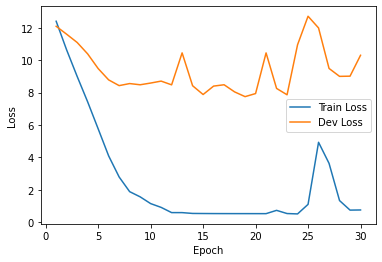

In [19]:
import matplotlib.pyplot as plt

t = list(range(1, 31))
plt.plot(t, train_losses, label="Train Loss")
plt.plot(t, dev_losses, label="Dev Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Inference

In [20]:
model = torch.load('dump/model.30')
model.eval()

BertForQuestionAnswering(
  (bert): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), ep

In [21]:
for idx, sample in zip(range(1, 4), sample_ds):
    print(f'------{idx}------')
    
    input_ids, token_type_ids, attention_mask = [
        torch.tensor(sample[key], dtype=torch.long, device="cuda")
        for key in ("input_ids", "token_type_ids","attention_mask")
    ]
    
    with torch.no_grad():
        start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :], attention_mask=attention_mask[None, :])
    start_logits.squeeze_(0), end_logits.squeeze_(0)
    
    start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
    end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
    probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
    index = torch.argmax(probability).item()
    
    start = index // len(end_prob)
    end = index % len(end_prob)
    print(sample['input_ids'].shape)
    answer = sample["input_ids"][int(start) : int(end) + 1]
    print(tokenizer.decode(answer))


    # start = sample['position'][start][0]
    # end = sample['position'][end][1]

    # print('Answer:', sample['context'][start:end])

------1------
torch.Size([512])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


이르
------2------


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


torch.Size([512])
수 있
------3------
torch.Size([512])
##부


In [22]:
test_dataset = KoMRC.load('/content/test.json')
test_dataset = TKIndexerWrappedDataset(test_dataset, tokenizer)
print("Number of Test Samples", len(test_dataset))
print(test_dataset[0])

4008


  0%|          | 0/6142 [00:00<?, ?it/s]


TypeError: ignored

In [ ]:
import csv

os.makedirs('out', exist_ok=True)
with torch.no_grad(), open('out/baseline.csv', 'w') as fd:
    writer = csv.writer(fd)
    writer.writerow(['Id', 'Predicted'])

    rows = []
    for sample in tqdm(test_dataset, "Testing"):

        input_ids, token_type_ids, attention_mask = [
            torch.tensor(sample[key], dtype=torch.long, device="cuda")
            for key in ("input_ids", "token_type_ids","attention_mask")
        ]
        
        with torch.no_grad():
            start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :], attention_mask=attention_mask[None, :])
        start_logits.squeeze_(0), end_logits.squeeze_(0)
        
        start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
        probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
        index = torch.argmax(probability).item()
        
        start = index // len(end_prob)
        end = index % len(end_prob)
        answer = sample["input_ids"][int(start) : int(end) + 1]
        last_answer = tokenizer.decode(answer)
        rows.append([sample["guid"], last_answer])


        # input_ids, token_type_ids = [
        #     torch.tensor(sample[key], dtype=torch.long, device="cuda")
        #     for key in ("input_ids", "token_type_ids")
        # ]
    
        # with torch.no_grad():
        #     start_logits, end_logits = model(input_ids=input_ids[None, :], token_type_ids=token_type_ids[None, :])
        # start_logits.squeeze_(0), end_logits.squeeze_(0)
    
        # start_prob = start_logits[token_type_ids.bool()][1:-1].softmax(-1)
        # end_prob = end_logits[token_type_ids.bool()][1:-1].softmax(-1)
        # probability = torch.triu(start_prob[:, None] @ end_prob[None, :])
        # index = torch.argmax(probability).item()
    
        # start = index // len(end_prob)
        # end = index % len(end_prob)
    
        # start = sample['position'][start][0]
        # end = sample['position'][end][1]

        # rows.append([sample["guid"], sample['context'][start:end]])
    
    writer.writerows(rows)